In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.image as mpimg
import pandas as pd
import wandb
import random
import numpy as np
from wandb.keras import WandbCallback

In [2]:
import visualkeras

In [3]:
BASE_DIR = 'teethdecay/teeth_dataset' #teethdecay
train_folder = os.path.join(BASE_DIR,'train')
test_folder = os.path.join(BASE_DIR,'test')

df_train = pd.DataFrame()
df_image = []
df_label = []

label_num = 0

for i_label in os.listdir(train_folder):
    for j_image in sorted(os.listdir(os.path.join(train_folder,i_label))): #return full images within the folder
        df_image.append(os.path.join('train',i_label,j_image)) # return path_image
        df_label.append(label_num)
    label_num += 1
df_train['images'] = df_image
df_train['target'] = df_label
#caries = 0, no-caries = 1
df_train.to_csv('./train.csv')

# TEST TO CSV
df_test = pd.DataFrame()
df_image = []
df_label = []

label_num = 0

for i_label in os.listdir(test_folder):
    for j_image in sorted(os.listdir(os.path.join(test_folder,i_label))): #return full images within the folder
        df_image.append(os.path.join('test',i_label,j_image))
        df_label.append(label_num)
    label_num += 1
df_test['images'] = df_image
df_test['target'] = df_label
#caries = 1, no-caries = 0
df_test.to_csv('./test.csv')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'teethdecay/teeth_dataset\\train'

In [11]:
df_train.tail(5),df_test.tail(5)

(                         images  target
 1255  train\no-caries\nc8_5.jpg       1
 1256  train\no-caries\nc8_6.jpg       1
 1257  train\no-caries\nc8_7.jpg       1
 1258  train\no-caries\nc8_8.jpg       1
 1259  train\no-caries\nc8_9.jpg       1,
                        images  target
 289  test\no-caries\nc9_5.jpg       1
 290  test\no-caries\nc9_6.jpg       1
 291  test\no-caries\nc9_7.jpg       1
 292  test\no-caries\nc9_8.jpg       1
 293  test\no-caries\nc9_9.jpg       1)

In [12]:
print('Number of train images:',len(df_train))
print('Number of test images:',len(df_test))

Number of train images: 1260
Number of test images: 294


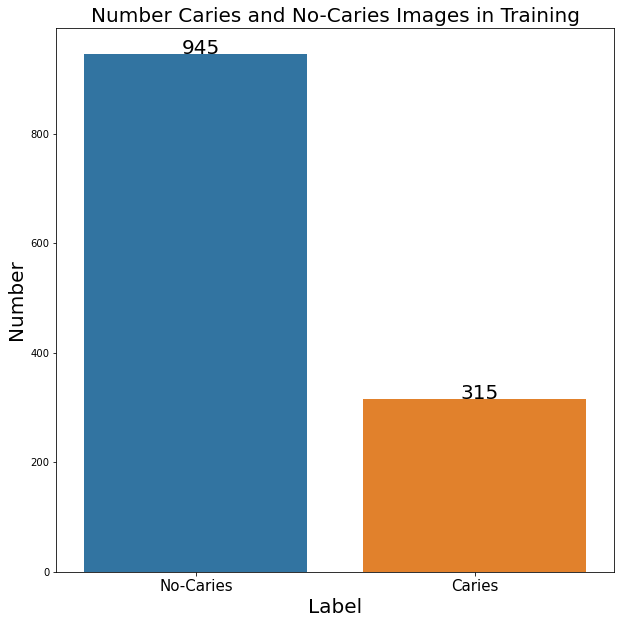

In [13]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x = 'target', data = df_train)
ax.set_title('Number Caries and No-Caries Images in Training', size=20)
ax.set_xlabel("Label",fontsize=20)
ax.set_ylabel("Number",fontsize=20)
ax.set_xticklabels(['No-Caries', 'Caries'],fontsize=15)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2),fontsize=20)

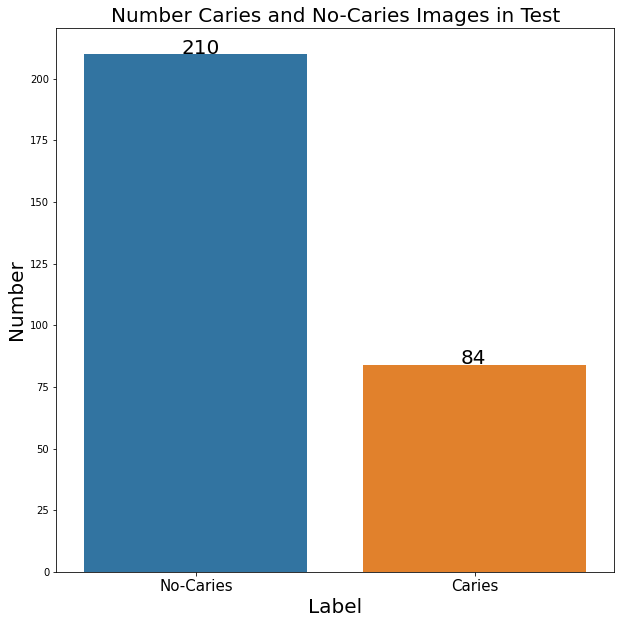

In [14]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x = 'target', data = df_test)
ax.set_title('Number Caries and No-Caries Images in Test', size=20)
ax.set_xlabel("Label",fontsize=20)
ax.set_ylabel("Number",fontsize=20)
ax.set_xticklabels(['No-Caries', 'Caries'],fontsize=15)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2),fontsize=20)

Text(0.5, 1.0, '% Carries and No-Caries In Train')

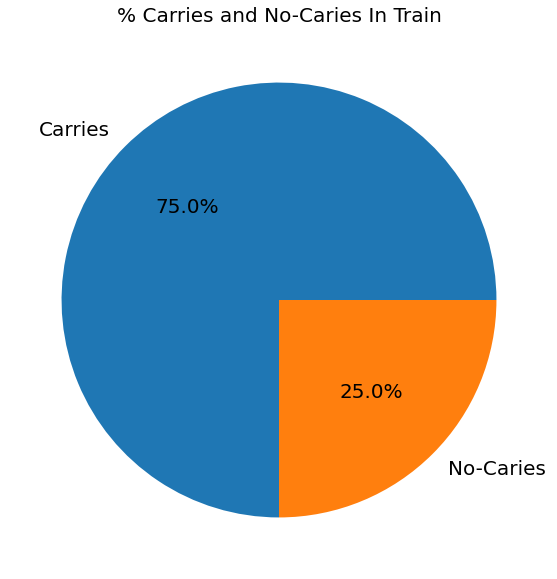

In [15]:
bar, ax = plt.subplots(figsize = (10,10))
bar.patch.set_facecolor('white')
plt.pie(df_train['target'].value_counts(), 
        labels = ['Carries','No-Caries'], 
        autopct="%.1f%%",textprops={'fontsize':20})
plt.title('% Carries and No-Caries In Train', size=20)

Text(0.5, 1.0, '% Carries and No-Caries In Test')

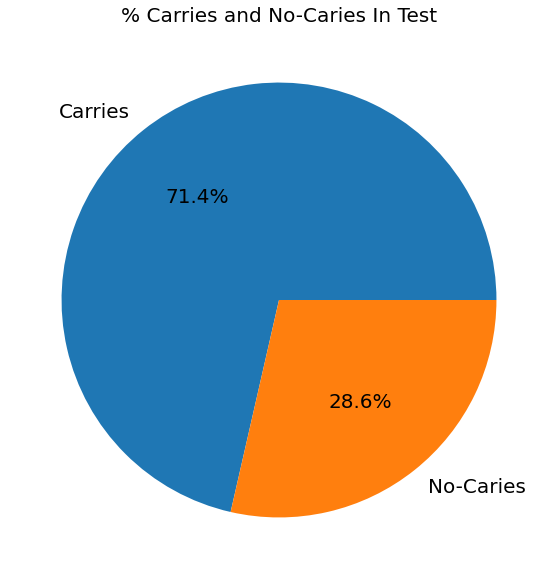

In [16]:
bar, ax = plt.subplots(figsize = (10,10))
bar.patch.set_facecolor('white')
plt.pie(df_test['target'].value_counts(), 
        labels = ['Carries','No-Caries'], 
        autopct="%.1f%%",textprops={'fontsize':20})
plt.title('% Carries and No-Caries In Test', size=20)

In [17]:
print('Choose 224x224 rescale is best choice')

Choose 224x224 rescale is best choice


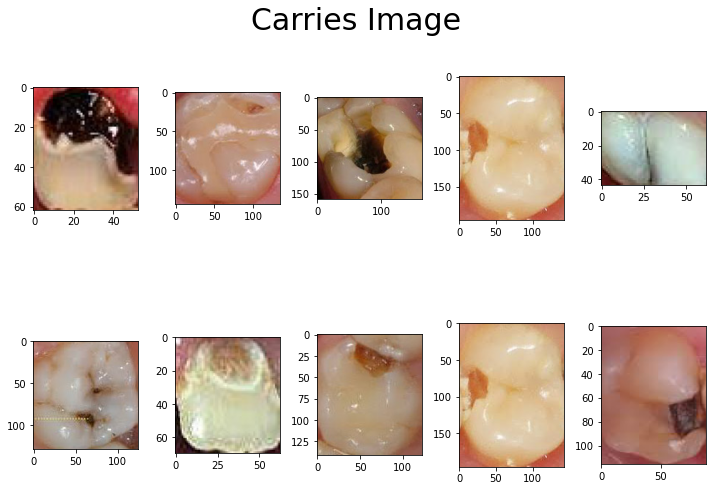

In [21]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
f.suptitle('Carries Image',x=0.5,y=0.8,fontsize=30,verticalalignment='bottom')
k = 0
for i in range(2):
    for j in range(5):
        img = cv2.imread(os.path.join('toothdecay/teeth_dataset','train','caries',random.choice(os.listdir(os.path.join('toothdecay/teeth_dataset','train','caries')))))
        # im_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k = k + 1
    plt.tight_layout()

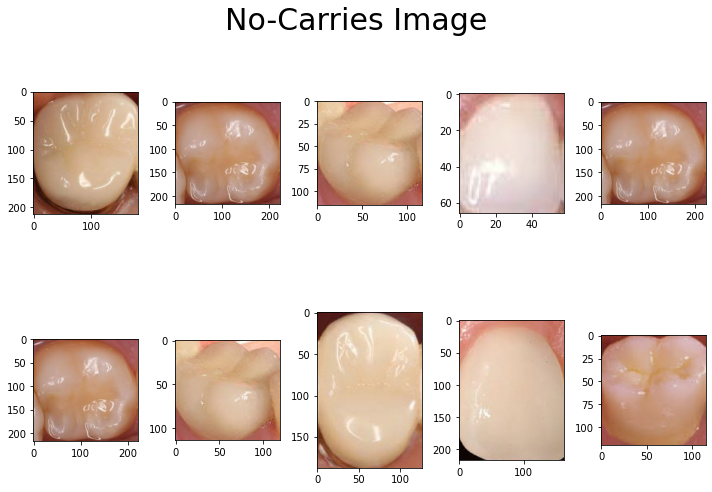

In [23]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
f.suptitle('No-Carries Image',x=0.5,y=0.8,fontsize=30,verticalalignment='bottom')
k = 0
for i in range(2):
    for j in range(5):
        img = cv2.imread(os.path.join('toothdecay/teeth_dataset','train','no-caries',random.choice(os.listdir(os.path.join('toothdecay/teeth_dataset','train','no-caries')))))
        # im_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k = k + 1
    plt.tight_layout()

In [24]:
train_generator = ImageDataGenerator( 
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
val_generator = ImageDataGenerator(rescale=1./255.)

In [25]:
train_datagen = train_generator.flow_from_directory(
    train_folder, 
    batch_size=10,
    target_size=(224, 224)
)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224)
)

Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


Found 60 images belonging to 2 classes.


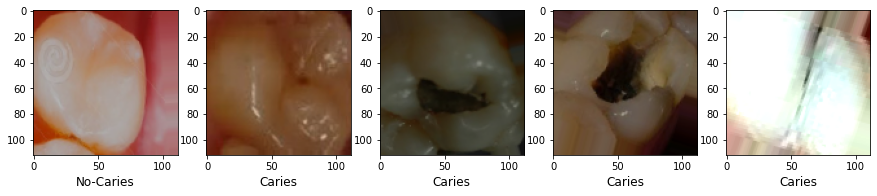

In [29]:
pic = train_generator.flow_from_directory(
    'toothdecay/teeth_dataset/train', 
    batch_size=1,
    target_size=(112, 112))
f,ax = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(5):
    img, label = pic.next()
    ax[i].imshow(img[0])
    ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

In [30]:
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224, 224, 3),weights=None,include_top=False,classes=2)

In [31]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.6))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 68992)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               35324416  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [32]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


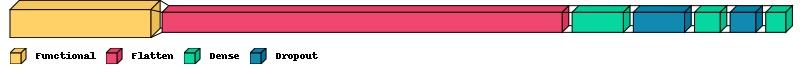

In [33]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(model, legend=True, font=font,to_file='output.png')

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [35]:
path_checkpoint = 'tmp/efficienetb0_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [36]:
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

C:\Users\vamsh\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
126/126 [==============================] - 489s 4s/step - loss: 1.4012 - accuracy: 0.6667 - val_loss: 0.6165 - val_accuracy: 0.7143

Epoch 00001: saving model to best_model.h5
Epoch 2/20
126/126 [==============================] - 471s 4s/step - loss: 1.0797 - accuracy: 0.6802 - val_loss: 0.5987 - val_accuracy: 0.7143

Epoch 00002: saving model to best_model.h5
Epoch 3/20
126/126 [==============================] - 530s 4s/step - loss: 0.8745 - accuracy: 0.7040 - val_loss: 0.5980 - val_accuracy: 0.7143

Epoch 00003: saving model to best_model.h5
Epoch 4/20
126/126 [==============================] - 553s 4s/step - loss: 0.8321 - accuracy: 0.7071 - val_loss: 0.5976 - val_accuracy: 0.7143

Epoch 00004: saving model to best_model.h5
Epoch 5/20
126/126 [==============================] - 556s 4s/step - loss: 0.7667 - accuracy: 0.7143 - val_loss: 0.6069 - val_accuracy: 0.7143

Epoch 00005: saving model to best_model.h5
Epoch 6/20
126/126 [==============================] - 542s 4s/ste

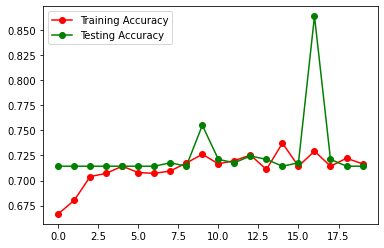

In [37]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

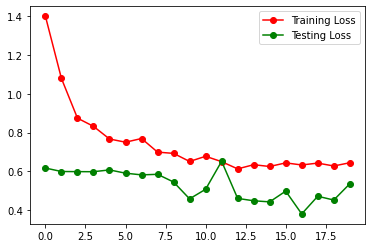

In [38]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [39]:
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)

Found 294 images belonging to 2 classes.


In [40]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [41]:
Y_pred  = model.predict(val_datagen).round()
Y_pred[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [42]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [43]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.71      1.00      0.83       210
   no-caries       0.00      0.00      0.00        84

   micro avg       0.71      0.71      0.71       294
   macro avg       0.36      0.50      0.42       294
weighted avg       0.51      0.71      0.60       294
 samples avg       0.71      0.71      0.71       294



C:\Users\vamsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

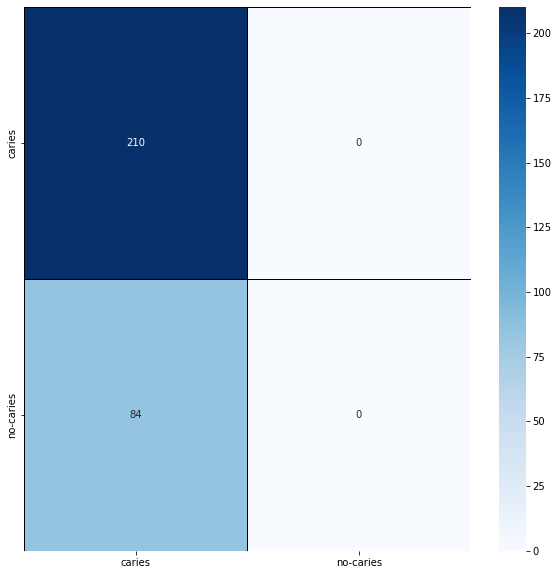

In [44]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [45]:
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.5


In [46]:
precision_score(Y_true_onehot,Y_pred,average=None)

C:\Users\vamsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.71428571, 0.        ])

In [47]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([1., 0.])

In [48]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.83333333, 0.        ])

In [49]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [50]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

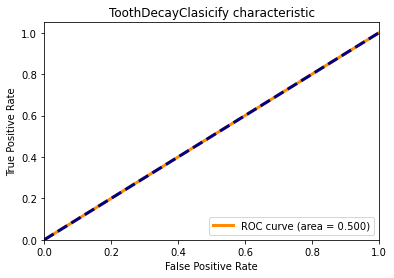

In [51]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

C:\Users\vamsh\AppData\Local\Temp/ipykernel_14852/2925625859.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


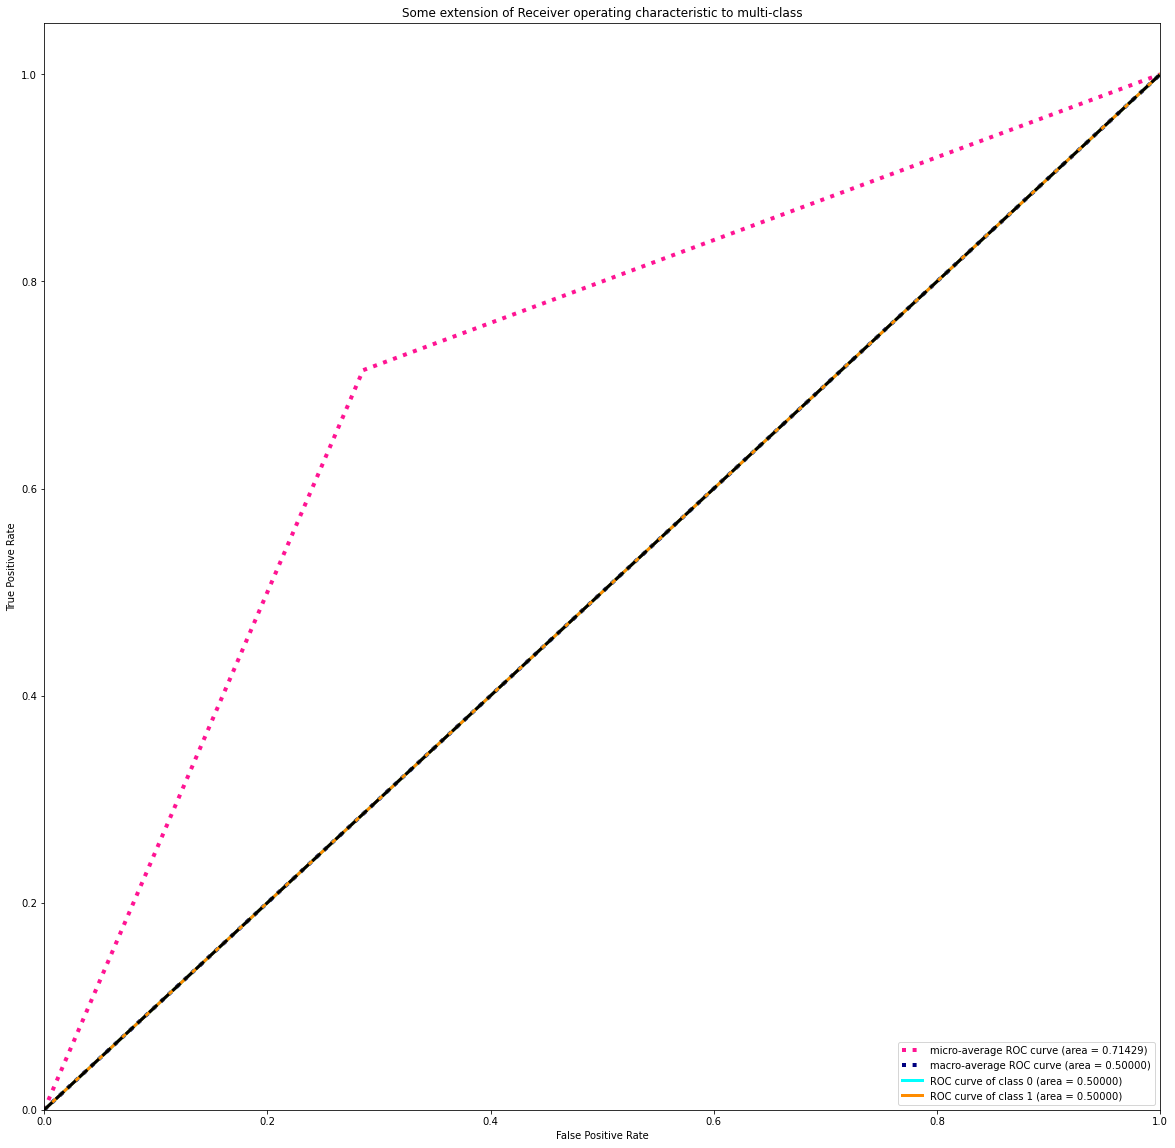

In [52]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [53]:
model.load_weights('best_model.h5')

In [54]:
classes = ['carries','no-caries']

In [ ]:
import cv2

In [ ]:
srcdir = 'toothdecay/teeth_dataset/test/caries'
count=0

for temp in os.listdir(srcdir):
    img = cv2.imread(os.path.join(srcdir, temp))
    cv2.imwrite(temp, img)
    cv2.imshow('caries', img)
    cv2.waitKey(0)
    img = cv2.resize(img, (112, 112))
    result = model.predict(img.reshape(1, 112, 112, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    count+=1
    if count>3:
        break